In [1]:
from google.colab import drive
drive.mount('/content/drive')
# from torch import __version__
# print(__version__)
# from pickle import format_version
# print(format_version)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
import torch
from fastai import *
from fastai.text import *
import os
import shutil
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import pickle

In [3]:
bs=12
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
# data_path='/home/taindp/Jupyter/ulmfit_intent/data/'
# data_path=os.path.dirname(data_path)
# models_path='/home/taindp/Jupyter/ulmfit_intent/models/'
# models_path=os.path.dirname(models_path)
data_path='/content/drive/MyDrive/Colab Notebooks/thesis/hcmut_sent_norm.csv'
# data_path=os.path.dirname(data_path)
models_path='/content/drive/My Drive/Colab Notebooks/data/models/'
# models_path=os.path.dirname(models_path)

## Create Dictionary Colab 

In [5]:
# data_reload=pd.read_csv(os.path.join(data_path,'preTrain.csv'),encoding='utf-8')
# data_reload.columns=['id','content']
# print(data_reload['content'].head())
# data = (TextList.from_df(data_reload,cols='content')
#             .split_by_rand_pct(0.1, seed=42)
#             .label_for_lm()           
#             .databunch(bs=bs, num_workers=0))
# data.save(os.path.join(data_path,'vi_databunch'))
# len(data.vocab.itos),len(data.train_ds)
# data = load_data(data_path,'vi_databunch.pkl',bs=bs)
# data.train_ds
# learn = language_model_learner(data, AWD_LSTM, drop_mult=0.9, pretrained=False)
# lr = 1e-2
# lr *= bs/24
# learn.unfreeze()
# learn.fit_one_cycle(1, lr, moms=(0.8,0.7))
# learn.save(os.path.join(data_path,'vi_wt'),with_opt=False)
# learn.data.vocab.save(os.path.join(data_path,'vi_wt_vocab.pkl'))

## Pretrain

In [6]:
df = pd.read_csv(data_path)
df.loc[pd.isna(df.content),'content']='NA'
df.head()

,label,content
0,0,anh chị cho em hỏi với ạ 3 tháng nữa là em thi...
1,0,anh chị ơi cho em hỏi giữa ngành du lịch với n...
2,0,anh chị ơi cho em xin hỏi ngành quản trị kinh ...
3,0,cho em xin ít thông tin về ngành công tác xã h...
4,0,cho em xin ý kiến về ngành marketing đi ạ


In [7]:
df_train,df_valid = train_test_split(df,stratify=df['label'],test_size=0.3,random_state=42)

In [8]:
df_train.shape,df_valid.shape

((159, 2), (69, 2))

In [9]:
data_lm = TextLMDataBunch.from_df(train_df = df_train, valid_df = df_valid, path = "")
# data_clas = TextClasDataBunch.from_df(path = "", train_df = df_train, valid_df = df_valid, vocab=data_lm.train_ds.vocab, bs=bs)

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


In [10]:
print(data_lm)

TextLMDataBunch;

Train: LabelList (159 items)
x: LMTextList
xxbos em chào mọi người ạ hiện em đã chọn được mình học kinh tế và phân vân 3 ngành tài chính ngân hàng kế toán quản trị kinh doanh,xxbos 1 số ngành em quan tâm là kinh doanh quốc tế kinh tế đối ngoại quản trị khách sạn quản trị lữ hành xxunk có anh chị nào đã tốt nghiệp các ngành xxunk tư vấn cho em với ạ,xxbos mọi người tư vấn cho em ngành tự động hoá cơ điện tử của đại học bách khoa hà nội với ạ,xxbos em muốn làm việc ở các xxunk xxunk công nghệ xxunk như xxunk xxunk thì nên chọn học ngành nào ở bách khoa ạ,xxbos em có đam mê với môn tin và công nghệ thông tin anh chị nào học công nghệ thông tin có thể tư vấn giúp em không
y: LMLabelList
,,,,
Path: .;

Valid: LabelList (69 items)
x: LMTextList
xxbos em sinh năm xxunk có ý định học marketing hoặc quản trị kinh doanh,xxbos hiện em đã chọn được mình học kinh tế và phân vân 3 ngành tài chính ngân hàng kế toán quản trị kinh doanh,xxbos em sinh năm xxunk học khối c00 có đam mê m

In [11]:
# df_learn=pd.concat([df_train,df_test],sort=False)

In [12]:
# data_lm = (TextList.from_df(df_learn, cols='content')
#     .split_by_rand_pct(0.1, seed=42)
#     .label_for_lm()           
#     .databunch(bs=bs, num_workers=0))

In [13]:
url_pth=os.path.join(models_path,'vi_wt')
url_pkl=os.path.join(models_path,'vi_wt_vocab')
lm_fns=[url_pth,url_pkl]

In [14]:
learn_lm = language_model_learner(data_lm, AWD_LSTM, pretrained_fnames=lm_fns, drop_mult=0.5)

In [15]:
lr = 1e-1
# lr *= bs/24

In [16]:
learn_lm.fit_one_cycle(10,lr, moms=(0.85, 0.65))

epoch,train_loss,valid_loss,accuracy,time
0,6.105097,5.852198,0.135045,00:00
1,6.076279,5.576190,0.157589,00:00
2,5.958851,4.990096,0.188839,00:00
3,5.744582,4.435585,0.216741,00:00
4,5.484617,4.011052,0.256027,00:00
5,5.229800,3.715120,0.292411,00:00
6,4.983891,3.573814,0.303125,00:00
7,4.772303,3.476075,0.318304,00:00
8,4.595917,3.434859,0.319196,00:00
9,4.445966,3.423673,0.319643,00:00


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


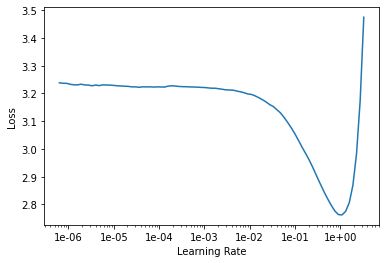

In [17]:
learn_lm.lr_find()
learn_lm.recorder.plot()

In [18]:
lr = 1e-1
learn_lm.unfreeze()
learn_lm.fit_one_cycle(8, lr, moms=(0.85,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,3.204203,3.330636,0.336384,00:00
1,3.144524,3.431193,0.345759,00:00
2,3.008105,3.619735,0.332589,00:00
3,2.991241,3.342136,0.405357,00:00
4,2.858072,3.010756,0.427455,00:00
5,2.684659,2.981103,0.456250,00:00
6,2.515663,2.965560,0.470089,00:00
7,2.374696,2.961371,0.478571,00:00


In [19]:
# learn_lm.save(os.path.join(models_path,'vifine_tuned'))
# learn_lm.save_encoder(os.path.join(models_path,'vifine_tuned_enc'))

In [20]:
# bs=21
data_classify = (TextList.from_df(df, vocab=data_lm.vocab, cols='content')
    .split_by_rand_pct(0.1, seed=42)
    .label_from_df(cols='label')
    .databunch(bs=bs, num_workers=0))

/usr/local/lib/python3.6/dist-packages/fastai/core.py:302: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(a, dtype=dtype, **kwargs)


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [21]:
data_classify.save(os.path.join(models_path,'data_classify'))

In [22]:
data_classify=load_data(models_path,'data_classify',bs=bs)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [23]:
# from fastai import F1ScoreMulti

In [24]:
# acc_02 = partial(accuracy_thresh, thresh=0.2)
# f_score = partial(fbeta, thresh=0.5, beta = 1)
learn_c = text_classifier_learner(data_classify, AWD_LSTM, drop_mult=0.65, metrics=[accuracy])
learn_c.load_encoder(os.path.join(models_path,'vifine_tuned_enc'))
learn_c.freeze()

In [25]:
lr=1e-1
lr *= bs/24

In [26]:
learn_c.fit_one_cycle(8, lr, moms=(0.85,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,0.577124,0.544878,0.818182,00:00
1,0.448610,0.687159,0.681818,00:00
2,0.487170,0.311590,0.909091,00:00
3,0.476174,0.123309,0.954545,00:00
4,0.463199,0.115788,0.954545,00:00
5,0.405182,0.148749,0.954545,00:00
6,0.381470,0.179824,0.954545,00:00
7,0.330421,0.161445,0.954545,00:00


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [27]:
learn_c.unfreeze()
learn_c.fit_one_cycle(2, lr, moms=(0.85,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,0.328902,0.183809,0.863636,00:00
1,0.437892,0.321149,0.863636,00:00


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [28]:
learn_c.freeze_to(-2)
learn_c.fit_one_cycle(2, lr, moms=(0.85,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,0.373475,0.367922,0.863636,00:00
1,0.463942,0.390378,0.863636,00:00


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [29]:
learn_c.freeze_to(-3)
learn_c.fit_one_cycle(8, slice(lr/2/(2.6**4),lr/2), moms=(0.85,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,0.426091,0.300527,0.954545,00:00
1,0.447231,0.220827,0.954545,00:00
2,0.447485,0.279726,0.909091,00:00
3,0.457624,0.168939,0.954545,00:00
4,0.444314,0.174155,1.000000,00:00
5,0.454440,0.221867,0.909091,00:00
6,0.430437,0.192762,0.954545,00:00
7,0.411958,0.226189,0.909091,00:00


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return ar

In [30]:
learn_c.unfreeze()
learn_c.fit_one_cycle(1, lr, moms=(0.85,0.65))

epoch,train_loss,valid_loss,accuracy,time
0,0.440812,0.217387,0.909091,00:00


/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


In [31]:
# learn_c.save(os.path.join(models_path,'vi_classify'))

In [34]:
learn_c.show_results(10)

text,target,prediction
xxbos em có tìm xxunk và được xxunk xxunk xxunk ngành văn học và ngôn ngữ của trường đại học khoa học xã hội và nhân văn em muốn biết xxunk nhiều hơn về ngành này và liệu sau này ra trường em có thể xin việc làm ở đâu được ạ,1,1
xxbos dạ theo em biết thì ngành quản trị kinh doanh sẽ học khá xxunk và không xxunk xxunk như vậy khi ra trường thì làm sao có thể làm ngành nào ổn định ạ và xxunk không xxunk như thế liệu doanh nghiệp xxunk xxunk vào để làm gì ạ,1,1
xxbos các bạn anh chị trong nhóm có thể tư vấn cho em một số ngành nghề sau ra trường dễ kiếm việc làm với ạ em cảm ơn nhiều em học khối a học lực khá em thích xxunk bên kỹ thuật công nghệ như điện tử cơ khí,1,1
xxbos em sinh năm học khối c00 có đam mê mãnh liệt về mảng nghiên cứu lịch sử chính trị văn hóa bản sắc của các quốc gia mọi người giúp em chọn ngành có cơ hội việc làm cao thu nhập ổn với ạ em xin cám ơn,1,1
xxbos chào mọi người em sinh năm xxunk đang có định hướng ở ngành quản lý nhà nước và quản trị kinh doanh ạ mong anh chị đi trước có kinh nghiệm tư vấn và chỉ dẫn cho em với ạ em xxunk thành cảm ơn,0,0
